# DSCI 100 Project: Individual Planning Stage

In [76]:
library(tidyverse)
library(cowplot)
library(repr)

players_url <- "https://raw.githubusercontent.com/oo74/DSCI-100-Project/d932a95bab3bbe9a443dcba02939882b0735483f/data/players.csv"
sessions_url <- "https://raw.githubusercontent.com/oo74/DSCI-100-Project/d932a95bab3bbe9a443dcba02939882b0735483f/data/sessions.csv"

players <- read_csv(players_url)
sessions <- read_csv(sessions_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## (1) Data Description:

The players.csv file contains 196 observations, each representing a unique player. 7 variables capture the demographic information and skill level of each player. Many players report zero hours of gameplay, but it is unclear whether it is because they are new or simply uninterested in playing. This distinction is important in the context of making predictions. For example, if 18-year-olds normally game a lot, but have few played hours because they only recently joined the study, it could skew the predicted played hours for similar age individuals. In addition, if the "experience" variable is self-reported, then designations may be subjective and unreliable as predictors.

| Variable Name | Type | Description | No. of Unique Values | Mean | Standard Deviation | Min | Max | Median |
| -------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| experience | fct (loaded in as chr) | level of experience the player has with gaming | 5 | | | | | |
| subscribe | lgl | whether the player is subscribed to the game's associated newsletter  | 2 | | | | | |
| hashedEmail | chr | player's email encrypted as a code | 196 | | | | | |
| played_hours | dbl | no. of hours the player has played on the Minecraft server | 43 | 5.845918 |28.35734 | 0 | 223.1 | 0.1 |
| name | chr | player's first name | 196 | | | | | |
| gender | fct (loaded in as chr) | player's gender | 7 | | | | | |
| Age | int (loaded in as dbl) | player's age in years | 31 | 20.52062 | 6.174667 | 8 | 50 | 19 |

---

The sessions.csv file has 1535 observations, each representing a single gaming session, with 5 variables which describe the start and end time of each session and the email associated with the player. Details regarding the time zone in which the time stamps were logged should be provided. If the recorded timestamps are in one zone but interpreted in another, the resulting prediction would be off by several hours, leading to incorrect conclusions about when players are actually most active.

| Variable Name | Type | Description |
| -------- | ------- | ------- |
| hashedEmail | chr | player's email encrypted as a code |
| start_time | chr | date and time at which the player begins the gaming session |
| end_time | chr | date and time at which the player ends the gaming session |
| original_start_time | dbl | start time for the gaming session as milliseconds that has passed since January 1st, 1970 |
| original_end_time | dbl | end time for the gaming session as milliseconds that has passed since January 1st, 1970 |

Overall, it is unclear whether data submission was mandatory for all players, raising concerns about representativeness if only a subset of the playerbase contributed data.

In [77]:
"No. of unique values for players dataset."
players |>
    map_df(n_distinct)

"Summary Statistics for played_hours in the players dataset"
players |>
    summarize(mean = mean(played_hours, na.rm = TRUE),
              SD = sd(played_hours, na.rm = TRUE),
              min = min(played_hours, na.rm = TRUE),
              max = max(played_hours, na.rm = TRUE),
              median = median(played_hours, na.rm = TRUE))

"Summary Statistics for age in the players dataset"
players |>
    summarize(mean = mean(Age, na.rm = TRUE),
              SD = sd(Age, na.rm = TRUE),
              min = min(Age, na.rm = TRUE),
              max = max(Age, na.rm = TRUE),
              median = median(Age, na.rm = TRUE))


[1] "No. of unique values for variables of interest."

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<int>,<int>,<int>,<int>,<int>,<int>,<int>
5,2,196,43,196,7,31


[1] "Summary Statistics for played_hours in the players dataset"

mean,SD,min,max,median
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.845918,28.35734,0,223.1,0.1


[1] "Summary Statistics for age in the players dataset"

mean,SD,min,max,median
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.52062,6.174667,8,50,19


## (2) Question:

I will address Question 2: what kinds of players are most likely to contribute a large amount of data? Specifically, I want to see whether **age** and **experience** can predict **number of hours played** (played_hours) based on the **players** dataset. Since those who spend more time playing produce more gameplay data, investigating these predictors can help the research group identify which age range/skill levels to target during recruiting.

Using **select()**, I will only keep the “Age,” “experience,” and “played_hours” variables from the players dataset since others are irrelevant to my question. Because experience is categorical, using **mutate()** and **fct_recode()**, I will turn its levels (Beginner, Amateur, Regular, Pro, and Veteran) into numeric values (1, 2, 3, 4, and 5) so that I can use them in a regression model.

## 3) Exploratory Data Analysis and Visualization

Fig. 1 shows that there is no obvious linear relationship between hours played and either age or experience. Most players are clustered near 0 hours, while a few outliers report much higher played hours (150+). The figure also indicates that the majority of players are between about 15 and 28 years old. Interestingly, Fig. 2 suggests that regular players have the highest average played hours, followed by amateurs, pros, beginners, and finally, veterans. I found this surprising as I assumed that more experienced players (pros and veterans) would play more. However, the outliers in Fig. 1 may explain why the regular and amateur players’ average hours are so high: several regulars have between 150–250 hours, and one amateur has around 150 hours, which greatly increases the overall average for both of these groups. Finally, Fig. 3 shows that non-binary players tend to have the highest played hours, followed by female, agender, male, those who preferred not to answer, other, and two-spirited players. The average played_hours of the three lowest gender groups are close to 0 hours.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


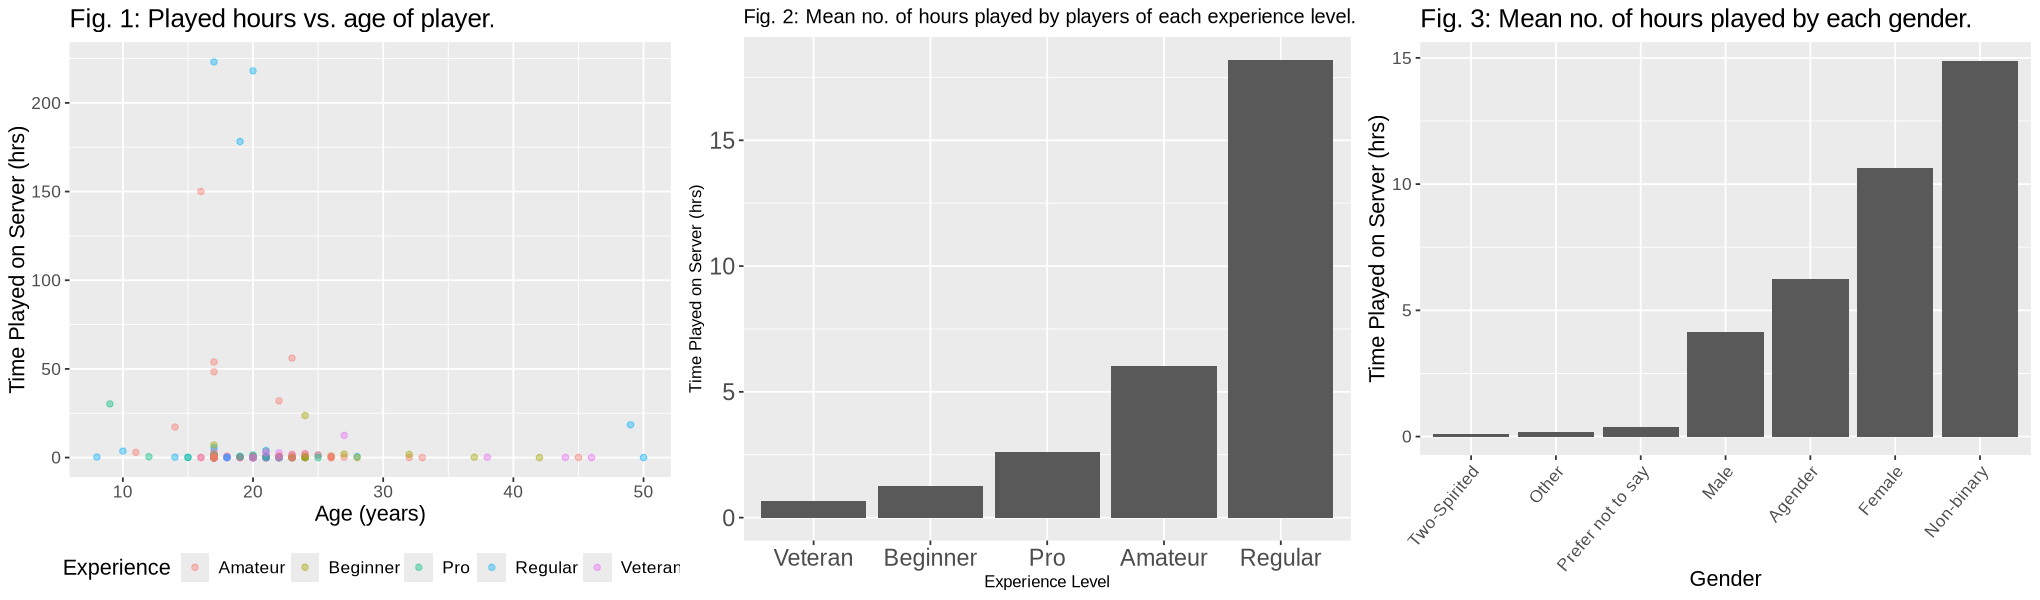

In [78]:
options(repr.plot.width = 17, repr.plot.height = 5)

age_hours_scatterplot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = experience)) +
    geom_point(alpha = 0.4) +
    labs(x = "Age (years)", y = "Time Played on Server (hrs)", color = "Experience", title = "Fig. 1: Played hours vs. age of player.") +
    theme(text = element_text(size = 13), legend.position = "bottom")

experience_hours_barplot <- players |>
    group_by(experience) |>
    summarize(played_hours = mean(played_hours, na.rm = TRUE)) |>
    ggplot(aes(x = fct_reorder(experience, played_hours), y = played_hours)) +
    geom_bar(stat = "identity") +
    labs(x = "Experience Level", y = "Time Played on Server (hrs)", title = "Fig. 2: Mean no. of hours played by players of each experience level.") +
    theme(text = element_text(size = 10), axis.text= element_text(size = 14))

gender_hours_barplot <- players |>
    group_by(gender) |>
    summarize(played_hours = mean(played_hours, na.rm = TRUE)) |>
    ggplot(aes(x = fct_reorder(gender, played_hours), y = played_hours)) +
    geom_bar(stat = "identity") +
    labs(x = "Gender", y = "Time Played on Server (hrs)", title = "Fig. 3: Mean no. of hours played by each gender.") +
    theme(text = element_text(size = 13), axis.text.x = element_text(angle = 50, hjust = 1))

plot_grid(age_hours_scatterplot, experience_hours_barplot, gender_hours_barplot, ncol = 3)

## (4) Methods and Plan

Since the response variable is numeric, I will use regression to predict players' played hours from their age and experience level. More specifically, because there are no clear linear relationships (Fig. 1), KNN is more suitable than linear regression. KNN does not have many assumptions beyond the idea that observations close together in the multi-dimensional space formed by predictor variables (age and experience) have similar response variables. The dataset being small (196 observations) also makes it compatible with KNN. I will split 75% of the data into a training set and reserve the remaining 25% as a test set, giving the model sufficient data to learn on while still leaving enough unseen data for a reliable performance evaluation. For pre-processing, I will center and scale both predictors so that age and experience contribute equally to distance calculations. I will use 5-fold cross-validation on the training set to find the K that minimizes RMSE, since relying on a single split can produce misleading results if, by chance, it happens to be unrepresentative of the overall data. 5-fold is fairly computationally efficient and does not produce very small training subsets that can result in unstable performance estimates. I will test K values from 1 to 10 because the dataset is relatively small, meaning larger K values are likely to underfit it. After identifying the best K, I will finalize the model using that value and evaluate its prediction performance on the test set via RMSPE.